# Recitation 4: more Poisson processes and queueing systems

* Sampling from 1D and 2D Poisson processes
* Simulating single-server queueing systems from scratch

# Poisson processes

## 1D

Write functions for the two methods of sampling from the non-homogenous Poisson process with intensity

$$
\lambda(t)=10*t(1-t)^2(3-t),\qquad 0\leq t\leq 3.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def i(t):
    return 100*t*(1-t)**2*(3-t)

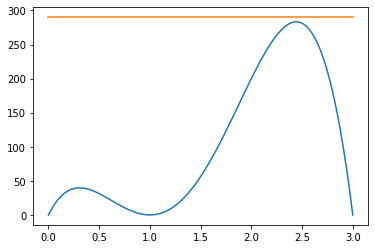

In [3]:
t = np.linspace(0, 3, 100)
plt.plot(t, i(t))
plt.plot(t, 290+0*t)

### Thinning

In [4]:
np.mean(i(t))*3

311.73637198430583

In [5]:
def sample_with_thinning():
    lmbda = 290
    t = 0
    
    samples = []
    
    while t < 3:
        t += np.random.exponential(1/lmbda)
        
        if np.random.rand() < i(t) / lmbda:
            samples.append(t)
    
    return samples

(array([ 7.,  7.,  5.,  0.,  0.,  7., 12., 26., 54., 46., 74., 52., 33.]),
 array([0.07131934, 0.29531969, 0.51932004, 0.74332038, 0.96732073,
        1.19132108, 1.41532142, 1.63932177, 1.86332212, 2.08732246,
        2.31132281, 2.53532316, 2.75932351, 2.98332385]),
 <BarContainer object of 13 artists>)

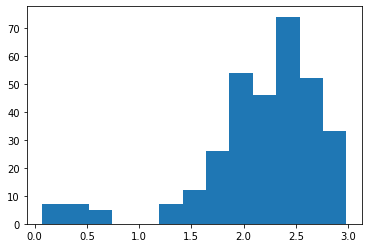

In [6]:
plt.hist(sample_with_thinning(), bins=13)

### Poisson distribution + order statistics

1. Sample $N_3$ using $N_3\sim\mbox{Pois}(\int_0^3\lambda(s)\,ds)$
2. Sample $T_i$ for $i=1,\dots,N_3$ using the fact that .... order statistics have pdf $\lambda(t)/\int_0^3\lambda(s)\,ds$

In [7]:
import sympy as sp

In [8]:
tt = sp.Symbol("t")

In [9]:
exp_N_3 = sp.Integral(i(tt), (tt, 0, 3)).doit()
exp_N_3

315

In [10]:
def dist_pt_given_N_3(t):
    return i(t) / exp_N_3

In [11]:
ss = sp.Symbol("s")

In [12]:
cdf = sp.Integral(dist_pt_given_N_3(tt), (tt, 0, ss)).doit()

In [13]:
cdf

-4*s**5/63 + 25*s**4/63 - 20*s**3/27 + 10*s**2/21

In [14]:
def numerical_inverse(y, acc=1e-3):
    # compute numerical inverse of CDF using binary search
    low, high = 0., 3.
    while high - low > acc:
        mid = (low + high) / 2
#         cdf_at_low = cdf.subs({ss: low})
#         cdf_at_high = cdf.subs({ss: high})
        cdf_at_mid = cdf.subs({ss: mid})
        if cdf_at_mid <= y:
            low = mid
        else:
            high = mid
    return mid

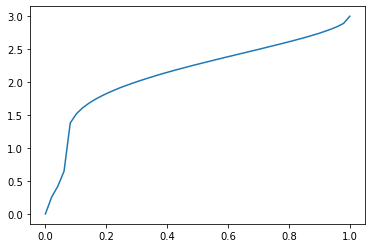

In [15]:
ys = np.linspace(0,1,50)
plt.plot(ys, [numerical_inverse(y) for y in ys])

In [16]:
def sample_with_inverse_transform_method():
    return numerical_inverse(np.random.rand())

In [17]:
def sample_with_order_stats():
    N_3 = np.random.poisson(exp_N_3)
    
    return sorted([sample_with_inverse_transform_method() for _ in range(N_3)])

(array([ 6.,  8.,  4.,  0.,  0.,  3., 20., 27., 45., 53., 61., 54., 25.]),
 array([0.1003418 , 0.32322341, 0.54610502, 0.76898663, 0.99186824,
        1.21474985, 1.43763146, 1.66051307, 1.88339468, 2.10627629,
        2.3291579 , 2.55203951, 2.77492112, 2.99780273]),
 <BarContainer object of 13 artists>)

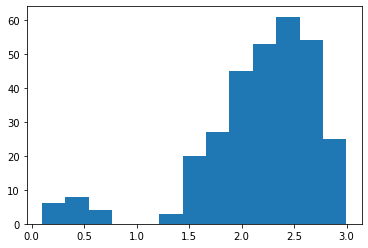

In [18]:
plt.hist(sample_with_order_stats(), bins=13)

## 2D

Write a function to sample from the non-homogenous Poisson point process in the unit circle with the following intensity function:

$$
\lambda(x,y)=2+x+y.
$$

In [19]:
x = 2*np.random.rand(1_000_000) - 1
y = 2*np.random.rand(1_000_000) - 1
val = 2+x+y
val[x**2+y**2>1] = 0

In [20]:
exp_lambda = np.mean(4*val)

In [21]:
exp_lambda

6.28705164637749

In [22]:
number = np.random.poisson(exp_lambda)
number

6

In [23]:
def sample_pts(number):
    # accept-reject sampling
    samples = []
    
    # upper bound on lambda(x,y) in unit circle
    c = 4

    while len(samples) < number:
        x, y = 2*np.random.rand(2)-1
        if x**2+y**2 > 1:
            # throw out points outside the unit circle
            continue
        if np.random.rand() < (2+x+y)/c:
            samples.append((x,y))
    
    return samples

In [24]:
def sample_2d():
    number = np.random.poisson(exp_lambda)

    return sample_pts(number)

In [25]:
def unzip_samples(samples):
    xs = []
    ys = []

    for x, y in samples:
        xs.append(x)
        ys.append(y)
    
    return xs, ys

In [26]:
lotsa_samples = []
for _ in range(20):
    lotsa_samples += sample_2d()

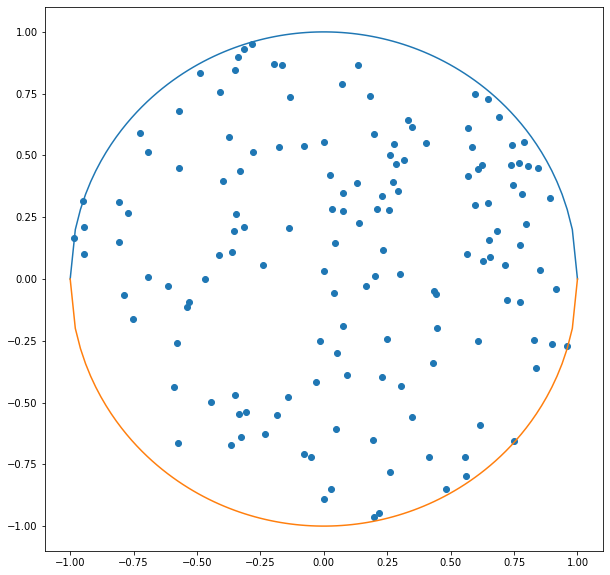

In [27]:
xs, ys = unzip_samples(lotsa_samples)

plt.figure(figsize=(10,10))
xx = np.linspace(-1,1,100)
plt.scatter(xs, ys)
plt.plot(xx, np.sqrt(1-xx**2))
plt.plot(xx, -np.sqrt(1-xx**2))

# Queueing systems

## Distribution of queue* length

*: buffer length

Consider an ice cream truck that has a single person handling all customers. It's a really freaking hot day. Throughout the day, customers arrive to the ice cream truck according to a homogenous Poisson process with an average rate of one customer every 9.8 minutes. Suppose that customers start arriving at 9 am, and the time taken to serve a single customer is independent and distributed according to a log-normal random variable with mean 10 minutes.

What is the distribution of number of customers being served or waiting to be served at noon?

In [28]:
def simulate_queue_length_at_noon():
    arrival_mean = 9.8 # min
    service_mean = 10.0 # min

    T = 60*3

    # event list
    events = []

    # pre-generate arrivals
    t = 0
    while t <= T:
        t += np.random.exponential(arrival_mean)
        events.append((t, "arrival"))

    # real simulation starts here
    customers_waiting = 0
    customer_in_service = False

    while events:
        # pick the next event
        time, event_type = events[0]

        # if we're past noon, stop
        if time > T:
            break

        if event_type == "arrival":
#             print(f"Customer arrived at time {time}")
            customers_waiting += 1
        elif event_type == "departure":
#             print(f"Customer departed at time {time}")
            assert customer_in_service
            customer_in_service = False

        if not customer_in_service and customers_waiting:
            customer_in_service = True
            customers_waiting -= 1
            service_time = np.random.lognormal(np.log(service_mean))
            events.append((time + service_time, "departure"))

        # remove the first event, and sort events by time, ready for the next iteration
        events = sorted(events[1:], key=lambda x: x[0])

#     print(f"{customers_waiting=}")
#     print(f"{customer_in_service=}")
    
    return customers_waiting + 1*customer_in_service

In [29]:
customers_at_noon = [simulate_queue_length_at_noon() for _ in range(10_000)]

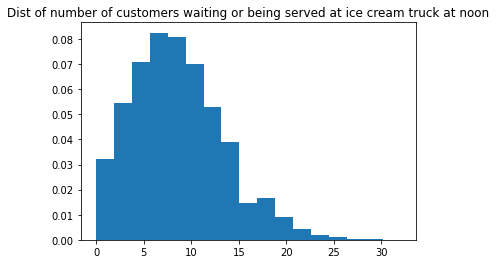

In [30]:
plt.hist(customers_at_noon, density=True, bins=17)
plt.title("Dist of number of customers waiting or being served at ice cream truck at noon");